In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(2)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 2
8
(6, 1)
1.0.0


In [4]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = "cpu"
print(device)

cuda:2


In [4]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                           
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


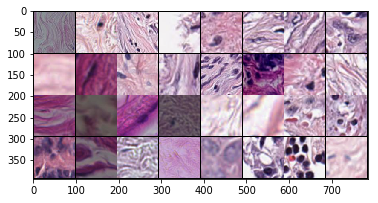

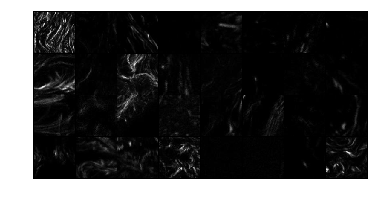

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.005)


===> Building model


In [9]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -ssim(output, targetf)
        
        p = 0.25
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(p*lossMSE.item()) +
                  " " + "lossSSIM: " + str((1-p)*lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [10]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [11]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [10]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.5622570514678955 lossSSIM: 0.07064183615148067
===> Epoch[1](0/25343): Loss: 0.6329
lossMSE: 0.5513356924057007 lossSSIM: 0.029091655276715755
===> Epoch[1](50/25343): Loss: 0.5804
lossMSE: 0.537771999835968 lossSSIM: 0.026364365592598915
===> Epoch[1](100/25343): Loss: 0.5641
lossMSE: 0.5335825681686401 lossSSIM: 0.024731559678912163
===> Epoch[1](150/25343): Loss: 0.5583
lossMSE: 0.5371059775352478 lossSSIM: 0.024059873074293137
===> Epoch[1](200/25343): Loss: 0.5612
lossMSE: 0.5089127421379089 lossSSIM: 0.02246028743684292
===> Epoch[1](250/25343): Loss: 0.5314
lossMSE: 0.521281898021698 lossSSIM: 0.024014325812458992
===> Epoch[1](300/25343): Loss: 0.5453
lossMSE: 0.5109140276908875 lossSSIM: 0.023282065987586975
===> Epoch[1](350/25343): Loss: 0.5342
lossMSE: 0.5139575600624084 lossSSIM: 0.02230474865064025
===> Epoch[1](400/25343): Loss: 0.5363
lossMSE: 0.5002774596214294 lossSSIM: 0.023182764183729887
===> Epoch[1](450/25343): Loss: 0.5235
lossMSE: 0.5001299381256104 

KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
            for img in input_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)
                            
            for img in label_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


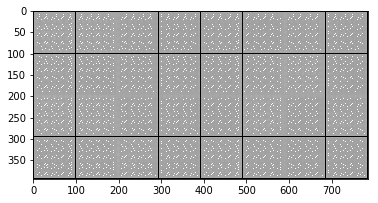

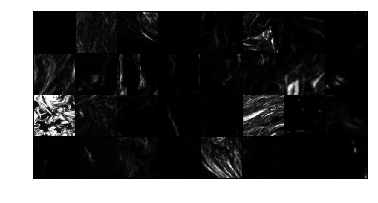

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


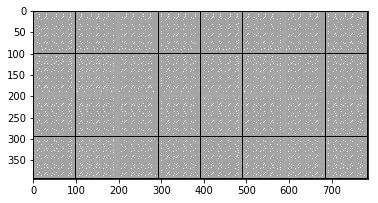

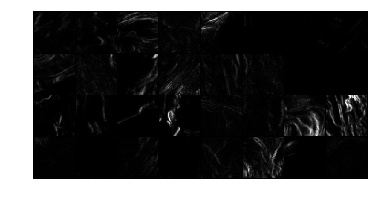

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


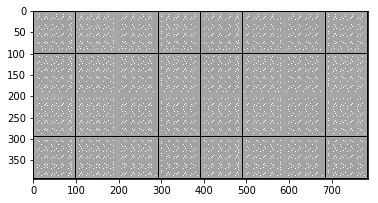

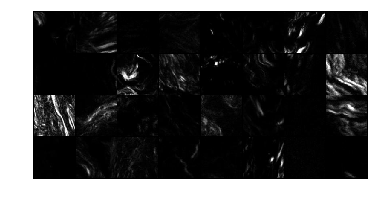

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


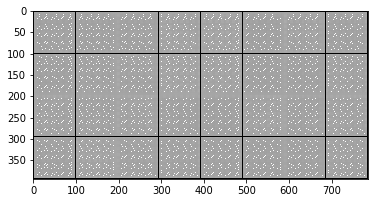

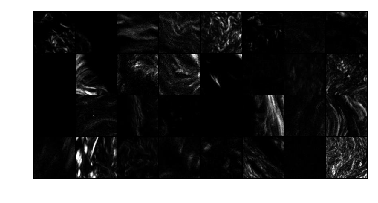

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


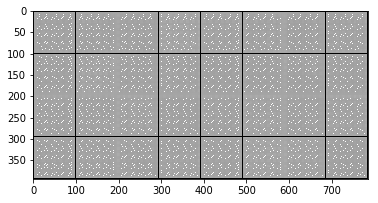

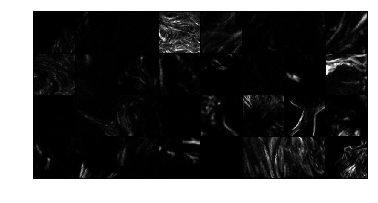

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


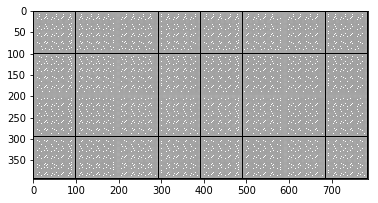

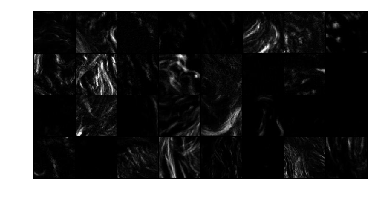

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


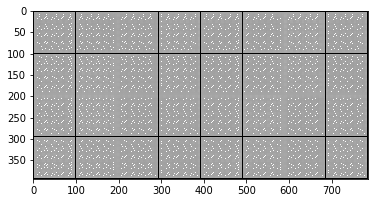

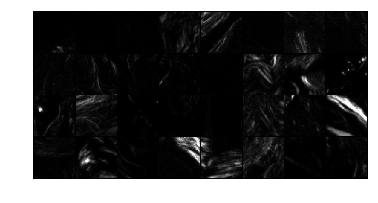

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


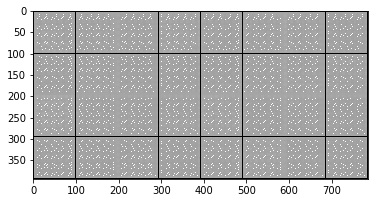

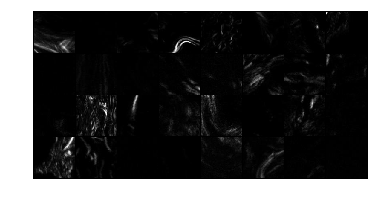

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


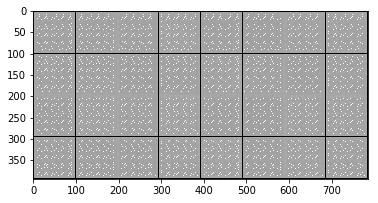

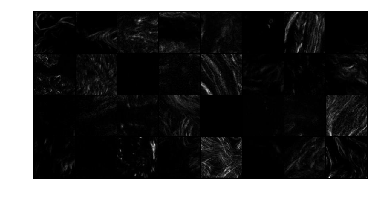

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


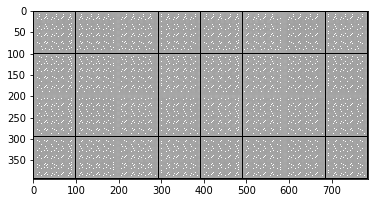

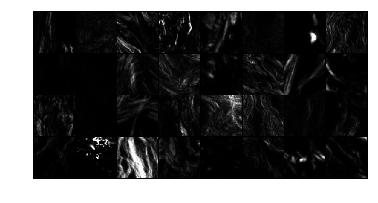

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


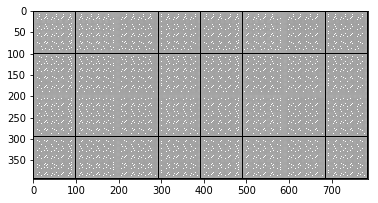

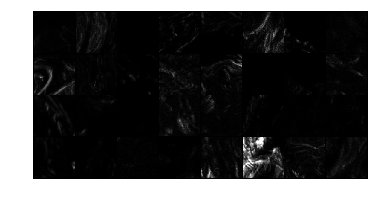

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


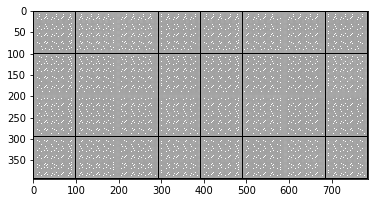

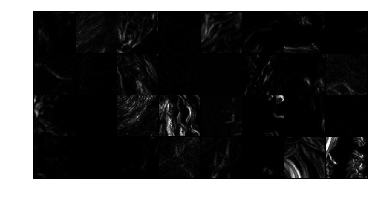

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


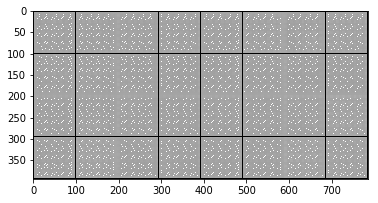

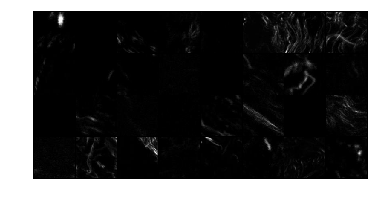

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


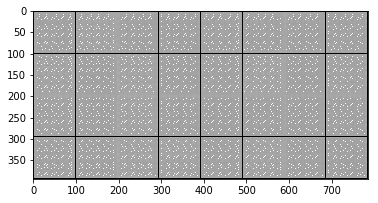

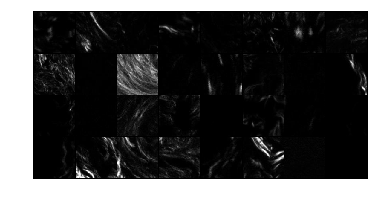

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


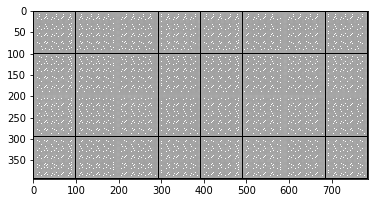

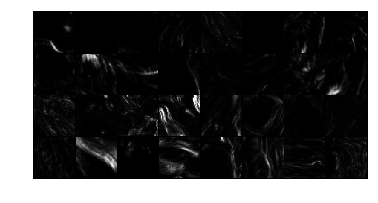

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


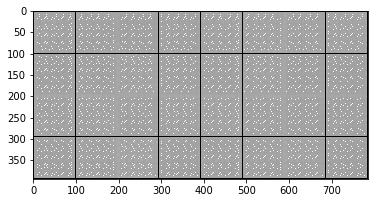

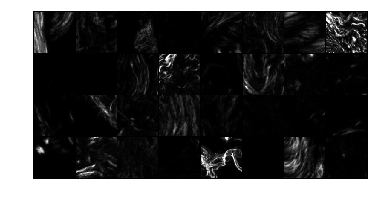

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


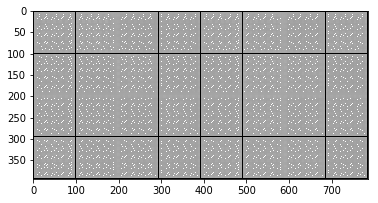

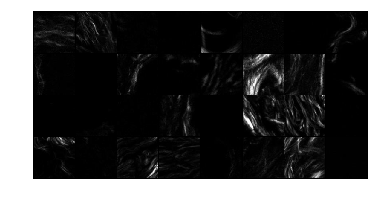

===> Avg. PSNR: 0.0068 dB


In [21]:
test()

In [22]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.4024791121482849 lossSSIM: 0.013285013381391764
===> Epoch[1](0/25343): Loss: 0.4158
lossMSE: 0.4079163670539856 lossSSIM: 0.012941282708197832
===> Epoch[1](50/25343): Loss: 0.4209
lossMSE: 0.4029497504234314 lossSSIM: 0.013058004900813103
===> Epoch[1](100/25343): Loss: 0.4160
lossMSE: 0.3943600058555603 lossSSIM: 0.012351583689451218
===> Epoch[1](150/25343): Loss: 0.4067
lossMSE: 0.38638728857040405 lossSSIM: 0.011794013902544975
===> Epoch[1](200/25343): Loss: 0.3982
lossMSE: 0.40278157591819763 lossSSIM: 0.011765838135033846
===> Epoch[1](250/25343): Loss: 0.4145
lossMSE: 0.39697393774986267 lossSSIM: 0.012090745847672224
===> Epoch[1](300/25343): Loss: 0.4091
lossMSE: 0.39133894443511963 lossSSIM: 0.011706587858498096
===> Epoch[1](350/25343): Loss: 0.4030
lossMSE: 0.3863323926925659 lossSSIM: 0.010711137671023607
===> Epoch[1](400/25343): Loss: 0.3970
lossMSE: 0.39665380120277405 lossSSIM: 0.011119351722300053
===> Epoch[1](450/25343): Loss: 0.4078
lossMSE: 0.3872717

lossMSE: 0.29958340525627136 lossSSIM: 0.0033518298296257854
===> Epoch[1](4150/25343): Loss: 0.3029
lossMSE: 0.28955531120300293 lossSSIM: 0.0032848503906279802
===> Epoch[1](4200/25343): Loss: 0.2928
lossMSE: 0.288776695728302 lossSSIM: 0.003164749941788614
===> Epoch[1](4250/25343): Loss: 0.2919
lossMSE: 0.2943645119667053 lossSSIM: 0.00309366371948272
===> Epoch[1](4300/25343): Loss: 0.2975
lossMSE: 0.29881131649017334 lossSSIM: 0.0032786634983494878
===> Epoch[1](4350/25343): Loss: 0.3021
lossMSE: 0.29224464297294617 lossSSIM: 0.003294352674856782
===> Epoch[1](4400/25343): Loss: 0.2955
lossMSE: 0.2874404191970825 lossSSIM: 0.0032565268920734525
===> Epoch[1](4450/25343): Loss: 0.2907
lossMSE: 0.29017549753189087 lossSSIM: 0.0032907177228480577
===> Epoch[1](4500/25343): Loss: 0.2935
lossMSE: 0.28278329968452454 lossSSIM: 0.0033647260861471295
===> Epoch[1](4550/25343): Loss: 0.2861
lossMSE: 0.2859894335269928 lossSSIM: 0.0030434089712798595
===> Epoch[1](4600/25343): Loss: 0.2890

lossMSE: 0.27104824781417847 lossSSIM: 0.0018884726450778544
===> Epoch[1](8250/25343): Loss: 0.2729
lossMSE: 0.2652362585067749 lossSSIM: 0.0018570654792711139
===> Epoch[1](8300/25343): Loss: 0.2671
lossMSE: 0.2618444561958313 lossSSIM: 0.0018168794922530651
===> Epoch[1](8350/25343): Loss: 0.2637
lossMSE: 0.2680487632751465 lossSSIM: 0.0019005280919373035
===> Epoch[1](8400/25343): Loss: 0.2699
lossMSE: 0.2633730173110962 lossSSIM: 0.0017825886025093496
===> Epoch[1](8450/25343): Loss: 0.2652
lossMSE: 0.265957236289978 lossSSIM: 0.0018202460487373173
===> Epoch[1](8500/25343): Loss: 0.2678
lossMSE: 0.270090788602829 lossSSIM: 0.0018678653868846595
===> Epoch[1](8550/25343): Loss: 0.2720
lossMSE: 0.26737290620803833 lossSSIM: 0.0016862842021510005
===> Epoch[1](8600/25343): Loss: 0.2691
lossMSE: 0.2737921476364136 lossSSIM: 0.0017972117057070136
===> Epoch[1](8650/25343): Loss: 0.2756
lossMSE: 0.2758892774581909 lossSSIM: 0.0017972055939026177
===> Epoch[1](8700/25343): Loss: 0.2777


lossMSE: 0.26622670888900757 lossSSIM: 0.0016157826175913215
===> Epoch[1](12350/25343): Loss: 0.2678
lossMSE: 0.2599722146987915 lossSSIM: 0.0014858156209811568
===> Epoch[1](12400/25343): Loss: 0.2615
lossMSE: 0.26116639375686646 lossSSIM: 0.001578133029397577
===> Epoch[1](12450/25343): Loss: 0.2627
lossMSE: 0.2612411379814148 lossSSIM: 0.0014369031123351306
===> Epoch[1](12500/25343): Loss: 0.2627
lossMSE: 0.2663532495498657 lossSSIM: 0.0015054299728944898
===> Epoch[1](12550/25343): Loss: 0.2679
lossMSE: 0.26046404242515564 lossSSIM: 0.0016009229002520442
===> Epoch[1](12600/25343): Loss: 0.2621
lossMSE: 0.26962417364120483 lossSSIM: 0.00142337751458399
===> Epoch[1](12650/25343): Loss: 0.2710
lossMSE: 0.272601455450058 lossSSIM: 0.001504534506238997
===> Epoch[1](12700/25343): Loss: 0.2741
lossMSE: 0.25950899720191956 lossSSIM: 0.001500792510341853
===> Epoch[1](12750/25343): Loss: 0.2610
lossMSE: 0.2564416825771332 lossSSIM: 0.0015179261681623757
===> Epoch[1](12800/25343): Loss

lossMSE: 0.25907546281814575 lossSSIM: 0.0015008501359261572
===> Epoch[1](16400/25343): Loss: 0.2606
lossMSE: 0.2635578215122223 lossSSIM: 0.0014713648706674576
===> Epoch[1](16450/25343): Loss: 0.2650
lossMSE: 0.2649681270122528 lossSSIM: 0.0014297148445621133
===> Epoch[1](16500/25343): Loss: 0.2664
lossMSE: 0.26547855138778687 lossSSIM: 0.001376743835862726
===> Epoch[1](16550/25343): Loss: 0.2669
lossMSE: 0.2638476490974426 lossSSIM: 0.0013992873136885464
===> Epoch[1](16600/25343): Loss: 0.2652
lossMSE: 0.2705738842487335 lossSSIM: 0.0014569697377737612
===> Epoch[1](16650/25343): Loss: 0.2720
lossMSE: 0.25189587473869324 lossSSIM: 0.0015106435166671872
===> Epoch[1](16700/25343): Loss: 0.2534
lossMSE: 0.2582364082336426 lossSSIM: 0.0014818764757364988
===> Epoch[1](16750/25343): Loss: 0.2597
lossMSE: 0.2621102035045624 lossSSIM: 0.0014426471607293934
===> Epoch[1](16800/25343): Loss: 0.2636
lossMSE: 0.26054155826568604 lossSSIM: 0.0012267486308701336
===> Epoch[1](16850/25343): 

lossMSE: 0.2647043466567993 lossSSIM: 0.0013153607142157853
===> Epoch[1](20500/25343): Loss: 0.2660
lossMSE: 0.2634751498699188 lossSSIM: 0.001284374127862975
===> Epoch[1](20550/25343): Loss: 0.2648
lossMSE: 0.2702058255672455 lossSSIM: 0.0014662316534668207
===> Epoch[1](20600/25343): Loss: 0.2717
lossMSE: 0.2507511377334595 lossSSIM: 0.0015287934802472591
===> Epoch[1](20650/25343): Loss: 0.2523
lossMSE: 0.2572825253009796 lossSSIM: 0.0013731099315918982
===> Epoch[1](20700/25343): Loss: 0.2587
lossMSE: 0.26217493414878845 lossSSIM: 0.0014709174865856767
===> Epoch[1](20750/25343): Loss: 0.2636
lossMSE: 0.26901254057884216 lossSSIM: 0.00141216951305978
===> Epoch[1](20800/25343): Loss: 0.2704
lossMSE: 0.25187423825263977 lossSSIM: 0.0015561249456368387
===> Epoch[1](20850/25343): Loss: 0.2534
lossMSE: 0.268393874168396 lossSSIM: 0.0014324399235192686
===> Epoch[1](20900/25343): Loss: 0.2698
lossMSE: 0.26499587297439575 lossSSIM: 0.0013965535908937454
===> Epoch[1](20950/25343): Los

lossMSE: 0.2650553286075592 lossSSIM: 0.0014947035815566778
===> Epoch[1](24600/25343): Loss: 0.2666
lossMSE: 0.2586122751235962 lossSSIM: 0.0015886006294749677
===> Epoch[1](24650/25343): Loss: 0.2602
lossMSE: 0.2656457722187042 lossSSIM: 0.0014516712399199605
===> Epoch[1](24700/25343): Loss: 0.2671
lossMSE: 0.24934345483779907 lossSSIM: 0.0015784450806677341
===> Epoch[1](24750/25343): Loss: 0.2509
lossMSE: 0.2559545338153839 lossSSIM: 0.0014546608726959676
===> Epoch[1](24800/25343): Loss: 0.2574
lossMSE: 0.25799381732940674 lossSSIM: 0.001473445852752775
===> Epoch[1](24850/25343): Loss: 0.2595
lossMSE: 0.25938650965690613 lossSSIM: 0.00147196400212124
===> Epoch[1](24900/25343): Loss: 0.2609
lossMSE: 0.2697165310382843 lossSSIM: 0.0014458552468568087
===> Epoch[1](24950/25343): Loss: 0.2712
lossMSE: 0.2588086724281311 lossSSIM: 0.0013644365826621652
===> Epoch[1](25000/25343): Loss: 0.2602
lossMSE: 0.26529595255851746 lossSSIM: 0.0014316556917037815
===> Epoch[1](25050/25343): Lo

lossMSE: 0.2632540464401245 lossSSIM: 0.0014745845692232251
===> Epoch[2](3350/25343): Loss: 0.2647
lossMSE: 0.25720202922821045 lossSSIM: 0.0013924590311944485
===> Epoch[2](3400/25343): Loss: 0.2586
lossMSE: 0.26134350895881653 lossSSIM: 0.0014160696300677955
===> Epoch[2](3450/25343): Loss: 0.2628
lossMSE: 0.26216739416122437 lossSSIM: 0.0014314828149508685
===> Epoch[2](3500/25343): Loss: 0.2636
lossMSE: 0.26308169960975647 lossSSIM: 0.0015720846131443977
===> Epoch[2](3550/25343): Loss: 0.2647


KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
            for img in input_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)
                            
            for img in label_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


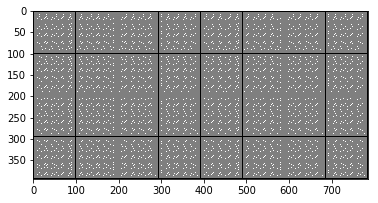

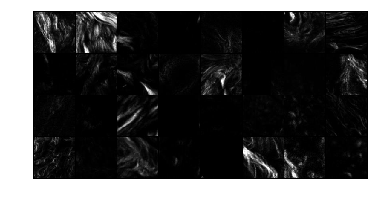

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


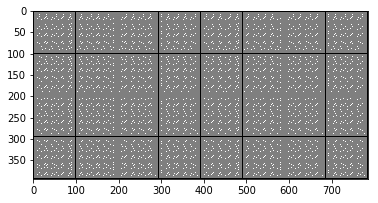

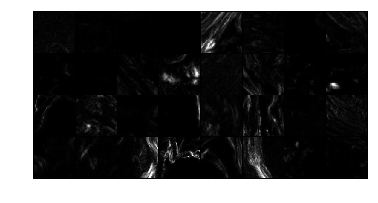

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


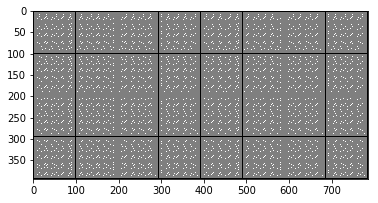

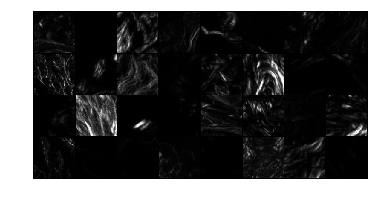

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


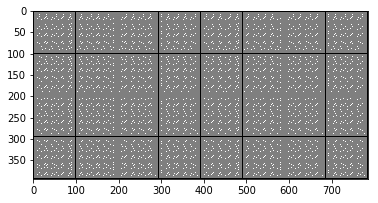

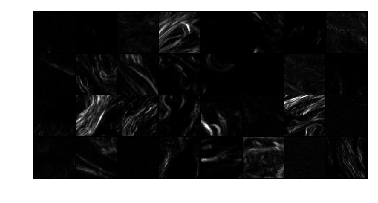

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


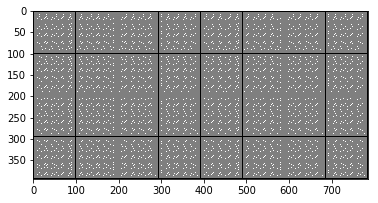

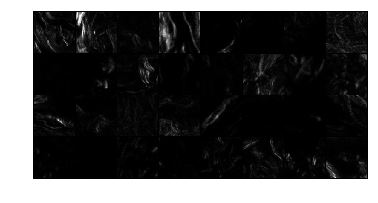

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


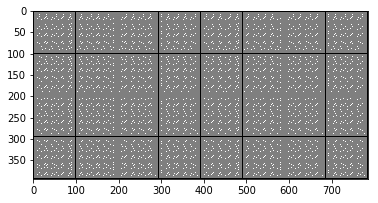

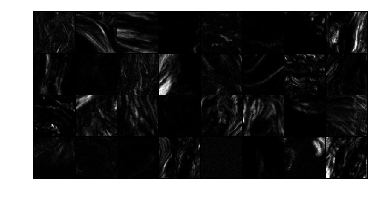

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


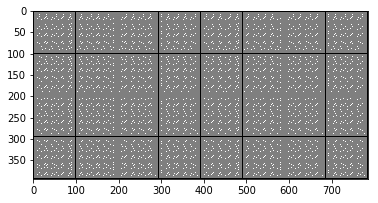

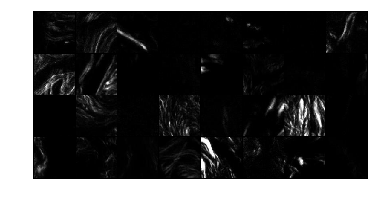

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


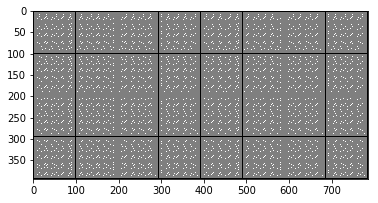

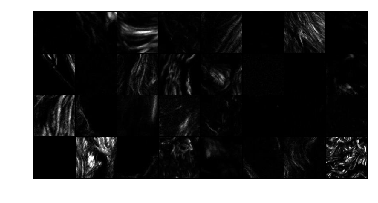

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


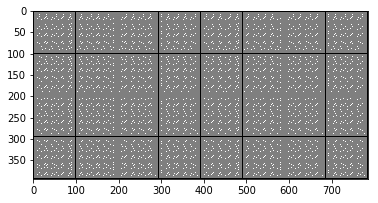

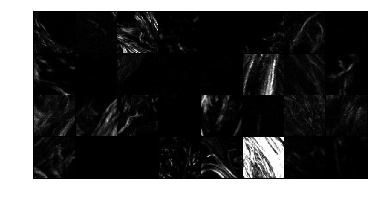

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


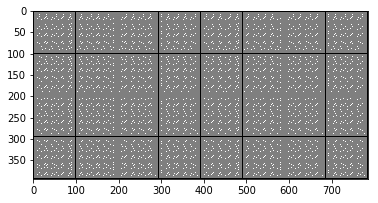

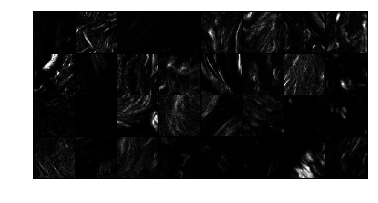

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


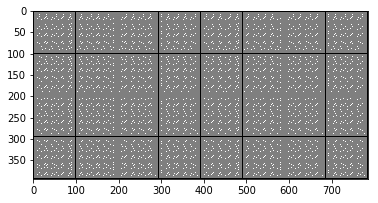

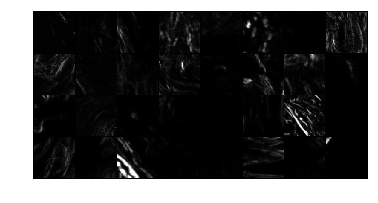

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


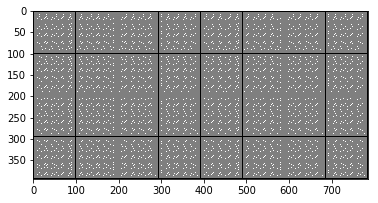

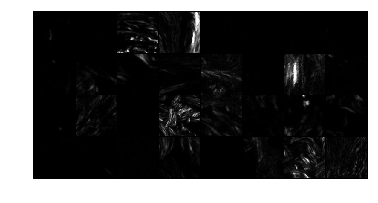

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


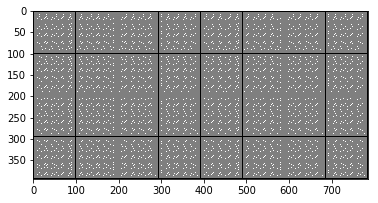

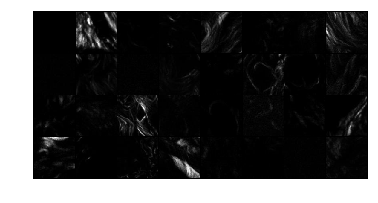

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


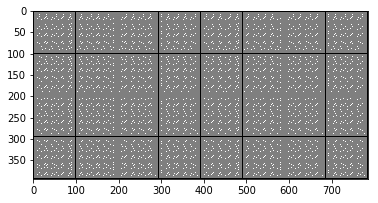

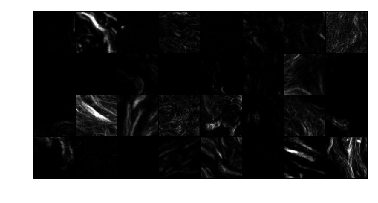

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


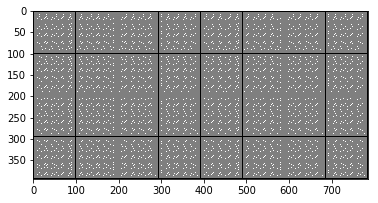

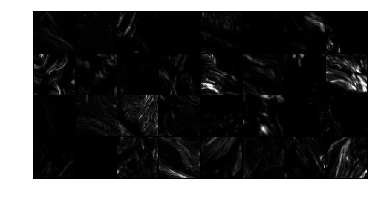

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


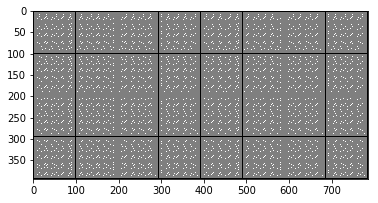

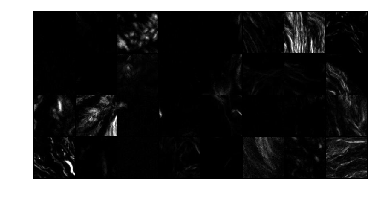

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


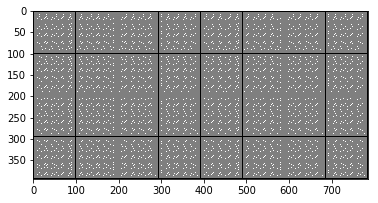

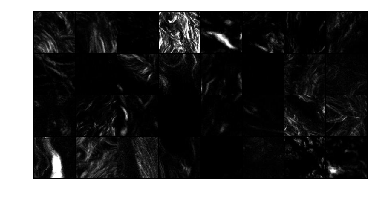

===> Avg. PSNR: 0.0081 dB


In [24]:
test()

In [25]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.2632025480270386 lossSSIM: 0.0014457108336500823
===> Epoch[1](0/25343): Loss: 0.2646
lossMSE: 0.26612138748168945 lossSSIM: 0.0015527019859291613
===> Epoch[1](50/25343): Loss: 0.2677
lossMSE: 0.2585975229740143 lossSSIM: 0.001472305040806532
===> Epoch[1](100/25343): Loss: 0.2601
lossMSE: 0.26473793387413025 lossSSIM: 0.0014282198098953813
===> Epoch[1](150/25343): Loss: 0.2662
lossMSE: 0.26187270879745483 lossSSIM: 0.0013934792659711093
===> Epoch[1](200/25343): Loss: 0.2633
lossMSE: 0.25140324234962463 lossSSIM: 0.0015343354898504913
===> Epoch[1](250/25343): Loss: 0.2529
lossMSE: 0.2606308162212372 lossSSIM: 0.0013728057383559644
===> Epoch[1](300/25343): Loss: 0.2620
lossMSE: 0.2589508295059204 lossSSIM: 0.0014198314456734806
===> Epoch[1](350/25343): Loss: 0.2604
lossMSE: 0.26372644305229187 lossSSIM: 0.0014964787987992167
===> Epoch[1](400/25343): Loss: 0.2652
lossMSE: 0.2637883126735687 lossSSIM: 0.0014684224734082818
===> Epoch[1](450/25343): Loss: 0.2653
lossMSE: 

lossMSE: 0.26166632771492004 lossSSIM: 0.0013773419195786119
===> Epoch[1](4100/25343): Loss: 0.2630
lossMSE: 0.26097726821899414 lossSSIM: 0.0013939425407443196
===> Epoch[1](4150/25343): Loss: 0.2624
lossMSE: 0.25803142786026 lossSSIM: 0.001302531163673848
===> Epoch[1](4200/25343): Loss: 0.2593
lossMSE: 0.26669275760650635 lossSSIM: 0.0013623689592350274
===> Epoch[1](4250/25343): Loss: 0.2681
lossMSE: 0.2686121165752411 lossSSIM: 0.001343481824733317
===> Epoch[1](4300/25343): Loss: 0.2700
lossMSE: 0.25318989157676697 lossSSIM: 0.0014438707439694554
===> Epoch[1](4350/25343): Loss: 0.2546
lossMSE: 0.2597745954990387 lossSSIM: 0.0014133427175693214
===> Epoch[1](4400/25343): Loss: 0.2612
lossMSE: 0.26219940185546875 lossSSIM: 0.0013670851767528802
===> Epoch[1](4450/25343): Loss: 0.2636
lossMSE: 0.2613004446029663 lossSSIM: 0.0014613691892009228
===> Epoch[1](4500/25343): Loss: 0.2628
lossMSE: 0.25505679845809937 lossSSIM: 0.0013247470487840474
===> Epoch[1](4550/25343): Loss: 0.256

lossMSE: 0.26717886328697205 lossSSIM: 0.0014737882884219289
===> Epoch[1](8200/25343): Loss: 0.2687
lossMSE: 0.27285611629486084 lossSSIM: 0.001492645824328065
===> Epoch[1](8250/25343): Loss: 0.2743
lossMSE: 0.2638576328754425 lossSSIM: 0.0014348973927553743
===> Epoch[1](8300/25343): Loss: 0.2653
lossMSE: 0.2521001696586609 lossSSIM: 0.0013131377636455
===> Epoch[1](8350/25343): Loss: 0.2534
lossMSE: 0.26617228984832764 lossSSIM: 0.001410012919222936
===> Epoch[1](8400/25343): Loss: 0.2676
lossMSE: 0.2551718056201935 lossSSIM: 0.0014419700601138175
===> Epoch[1](8450/25343): Loss: 0.2566
lossMSE: 0.26765674352645874 lossSSIM: 0.0014464491396211088
===> Epoch[1](8500/25343): Loss: 0.2691
lossMSE: 0.2699723243713379 lossSSIM: 0.001462705316953361
===> Epoch[1](8550/25343): Loss: 0.2714
lossMSE: 0.25277847051620483 lossSSIM: 0.0015605619410052896
===> Epoch[1](8600/25343): Loss: 0.2543
lossMSE: 0.26480600237846375 lossSSIM: 0.001494496304076165
===> Epoch[1](8650/25343): Loss: 0.2663
l

lossMSE: 0.25460338592529297 lossSSIM: 0.0015149338287301362
===> Epoch[1](12300/25343): Loss: 0.2561
lossMSE: 0.26322808861732483 lossSSIM: 0.0013682925200555474
===> Epoch[1](12350/25343): Loss: 0.2646
lossMSE: 0.2658911347389221 lossSSIM: 0.0013874154828954488
===> Epoch[1](12400/25343): Loss: 0.2673
lossMSE: 0.25575020909309387 lossSSIM: 0.0014147156034596264
===> Epoch[1](12450/25343): Loss: 0.2572
lossMSE: 0.26527515053749084 lossSSIM: 0.0014806604012846947
===> Epoch[1](12500/25343): Loss: 0.2668
lossMSE: 0.2600129544734955 lossSSIM: 0.0014561115531250834
===> Epoch[1](12550/25343): Loss: 0.2615
lossMSE: 0.2570435702800751 lossSSIM: 0.0014825943508185446
===> Epoch[1](12600/25343): Loss: 0.2585
lossMSE: 0.2655598521232605 lossSSIM: 0.0013592206814792007
===> Epoch[1](12650/25343): Loss: 0.2669
lossMSE: 0.2611922025680542 lossSSIM: 0.0014807353145442903
===> Epoch[1](12700/25343): Loss: 0.2627
lossMSE: 0.2611812949180603 lossSSIM: 0.0015139430179260671
===> Epoch[1](12750/25343):

lossMSE: 0.25930145382881165 lossSSIM: 0.0014628710341639817
===> Epoch[1](16350/25343): Loss: 0.2608
lossMSE: 0.26025429368019104 lossSSIM: 0.0013711928331758827
===> Epoch[1](16400/25343): Loss: 0.2616
lossMSE: 0.259597510099411 lossSSIM: 0.001415759150404483
===> Epoch[1](16450/25343): Loss: 0.2610
lossMSE: 0.2655981183052063 lossSSIM: 0.0014731327537447214
===> Epoch[1](16500/25343): Loss: 0.2671
lossMSE: 0.2550073266029358 lossSSIM: 0.0016019725590012968
===> Epoch[1](16550/25343): Loss: 0.2566
lossMSE: 0.25537943840026855 lossSSIM: 0.0015460472786799073
===> Epoch[1](16600/25343): Loss: 0.2569
lossMSE: 0.2586551308631897 lossSSIM: 0.0013418497110251337
===> Epoch[1](16650/25343): Loss: 0.2600
lossMSE: 0.2629307210445404 lossSSIM: 0.0015131992986425757
===> Epoch[1](16700/25343): Loss: 0.2644
lossMSE: 0.26616135239601135 lossSSIM: 0.0013999616203363985
===> Epoch[1](16750/25343): Loss: 0.2676
lossMSE: 0.2636171579360962 lossSSIM: 0.001493313757237047
===> Epoch[1](16800/25343): Lo

lossMSE: 0.26587796211242676 lossSSIM: 0.001425100606866181
===> Epoch[1](20450/25343): Loss: 0.2673
lossMSE: 0.26144030690193176 lossSSIM: 0.0014413756434805691
===> Epoch[1](20500/25343): Loss: 0.2629
lossMSE: 0.2644229531288147 lossSSIM: 0.0014857847127132118
===> Epoch[1](20550/25343): Loss: 0.2659
lossMSE: 0.2712276875972748 lossSSIM: 0.0013953571615274996
===> Epoch[1](20600/25343): Loss: 0.2726
lossMSE: 0.2626590132713318 lossSSIM: 0.0014224676415324211
===> Epoch[1](20650/25343): Loss: 0.2641
lossMSE: 0.2668479084968567 lossSSIM: 0.0015081146266311407
===> Epoch[1](20700/25343): Loss: 0.2684
lossMSE: 0.26696646213531494 lossSSIM: 0.0014597965346183628
===> Epoch[1](20750/25343): Loss: 0.2684
lossMSE: 0.2690403461456299 lossSSIM: 0.0014470167516265064
===> Epoch[1](20800/25343): Loss: 0.2705
lossMSE: 0.26173803210258484 lossSSIM: 0.0014643586473539472
===> Epoch[1](20850/25343): Loss: 0.2632
lossMSE: 0.26115861535072327 lossSSIM: 0.0014626835763920099
===> Epoch[1](20900/25343):

lossMSE: 0.2665378153324127 lossSSIM: 0.0014348046679515392
===> Epoch[1](24550/25343): Loss: 0.2680
lossMSE: 0.26417672634124756 lossSSIM: 0.0014947528252378106
===> Epoch[1](24600/25343): Loss: 0.2657
lossMSE: 0.25925391912460327 lossSSIM: 0.0014485299470834434
===> Epoch[1](24650/25343): Loss: 0.2607
lossMSE: 0.25619733333587646 lossSSIM: 0.0015091773821040988
===> Epoch[1](24700/25343): Loss: 0.2577
lossMSE: 0.2623155415058136 lossSSIM: 0.0015019678976386786
===> Epoch[1](24750/25343): Loss: 0.2638
lossMSE: 0.2741622030735016 lossSSIM: 0.001400648063281551
===> Epoch[1](24800/25343): Loss: 0.2756
lossMSE: 0.2562045454978943 lossSSIM: 0.0014375799510162324
===> Epoch[1](24850/25343): Loss: 0.2576
lossMSE: 0.2572309672832489 lossSSIM: 0.0015011707437224686
===> Epoch[1](24900/25343): Loss: 0.2587
lossMSE: 0.255182683467865 lossSSIM: 0.001369429228361696
===> Epoch[1](24950/25343): Loss: 0.2566
lossMSE: 0.2547062337398529 lossSSIM: 0.0014401467342395335
===> Epoch[1](25000/25343): Los

lossMSE: 0.2703167200088501 lossSSIM: 0.001486548688262701
===> Epoch[2](3300/25343): Loss: 0.2718
lossMSE: 0.2614389955997467 lossSSIM: 0.0014973166398704052
===> Epoch[2](3350/25343): Loss: 0.2629
lossMSE: 0.25547945499420166 lossSSIM: 0.0015118108713068068
===> Epoch[2](3400/25343): Loss: 0.2570
lossMSE: 0.2668706178665161 lossSSIM: 0.0014795421157032251
===> Epoch[2](3450/25343): Loss: 0.2684
lossMSE: 0.2593088150024414 lossSSIM: 0.0013006986700929701
===> Epoch[2](3500/25343): Loss: 0.2606
lossMSE: 0.26207971572875977 lossSSIM: 0.0014834086177870631
===> Epoch[2](3550/25343): Loss: 0.2636
lossMSE: 0.26112863421440125 lossSSIM: 0.0014292221458163112
===> Epoch[2](3600/25343): Loss: 0.2626
lossMSE: 0.26940712332725525 lossSSIM: 0.0013968590064905584
===> Epoch[2](3650/25343): Loss: 0.2708
lossMSE: 0.2561062276363373 lossSSIM: 0.001376659405650571
===> Epoch[2](3700/25343): Loss: 0.2575
lossMSE: 0.2634541690349579 lossSSIM: 0.0013999996008351445
===> Epoch[2](3750/25343): Loss: 0.264

lossMSE: 0.2658972144126892 lossSSIM: 0.001442981039872393
===> Epoch[2](7400/25343): Loss: 0.2673
lossMSE: 0.26671627163887024 lossSSIM: 0.0014517389936372638
===> Epoch[2](7450/25343): Loss: 0.2682
lossMSE: 0.25059646368026733 lossSSIM: 0.0011934599024243653
===> Epoch[2](7500/25343): Loss: 0.2518
lossMSE: 0.2607786953449249 lossSSIM: 0.0014086886658333242
===> Epoch[2](7550/25343): Loss: 0.2622
lossMSE: 0.25740551948547363 lossSSIM: 0.0013705368619412184
===> Epoch[2](7600/25343): Loss: 0.2588
lossMSE: 0.26093706488609314 lossSSIM: 0.0013843525084666908
===> Epoch[2](7650/25343): Loss: 0.2623
lossMSE: 0.26172935962677 lossSSIM: 0.0015261226217262447
===> Epoch[2](7700/25343): Loss: 0.2633
lossMSE: 0.26228490471839905 lossSSIM: 0.001446732465410605
===> Epoch[2](7750/25343): Loss: 0.2637
lossMSE: 0.26219043135643005 lossSSIM: 0.0013453105639200658
===> Epoch[2](7800/25343): Loss: 0.2635
lossMSE: 0.2644290626049042 lossSSIM: 0.001417234365362674
===> Epoch[2](7850/25343): Loss: 0.2658

lossMSE: 0.2586710751056671 lossSSIM: 0.0014346675015985966
===> Epoch[2](11500/25343): Loss: 0.2601
lossMSE: 0.267328143119812 lossSSIM: 0.001443259825464338
===> Epoch[2](11550/25343): Loss: 0.2688
lossMSE: 0.268515944480896 lossSSIM: 0.0014776738244108856
===> Epoch[2](11600/25343): Loss: 0.2700
lossMSE: 0.2590656578540802 lossSSIM: 0.0014019392256159335
===> Epoch[2](11650/25343): Loss: 0.2605
lossMSE: 0.26477494835853577 lossSSIM: 0.001326765603153035
===> Epoch[2](11700/25343): Loss: 0.2661
lossMSE: 0.2632536292076111 lossSSIM: 0.0014086993178352714
===> Epoch[2](11750/25343): Loss: 0.2647
lossMSE: 0.2554117441177368 lossSSIM: 0.0014086251030676067
===> Epoch[2](11800/25343): Loss: 0.2568
lossMSE: 0.2600975036621094 lossSSIM: 0.0013963861274532974
===> Epoch[2](11850/25343): Loss: 0.2615
lossMSE: 0.2533077001571655 lossSSIM: 0.0014831131557002664
===> Epoch[2](11900/25343): Loss: 0.2548
lossMSE: 0.2568308115005493 lossSSIM: 0.0015125233330763876
===> Epoch[2](11950/25343): Loss: 

lossMSE: 0.26346203684806824 lossSSIM: 0.001413562917150557
===> Epoch[2](15600/25343): Loss: 0.2649
lossMSE: 0.25190556049346924 lossSSIM: 0.0015560051542706788
===> Epoch[2](15650/25343): Loss: 0.2535
lossMSE: 0.2675982713699341 lossSSIM: 0.001337857567705214
===> Epoch[2](15700/25343): Loss: 0.2689
lossMSE: 0.25828853249549866 lossSSIM: 0.001400235778419301
===> Epoch[2](15750/25343): Loss: 0.2597
lossMSE: 0.2668430507183075 lossSSIM: 0.0015419209375977516
===> Epoch[2](15800/25343): Loss: 0.2684
lossMSE: 0.2616289556026459 lossSSIM: 0.0014185491017997265
===> Epoch[2](15850/25343): Loss: 0.2630
lossMSE: 0.27058616280555725 lossSSIM: 0.0014688237570226192
===> Epoch[2](15900/25343): Loss: 0.2721
lossMSE: 0.25878822803497314 lossSSIM: 0.0013177706860005856
===> Epoch[2](15950/25343): Loss: 0.2601
lossMSE: 0.26128748059272766 lossSSIM: 0.0014316410233732313
===> Epoch[2](16000/25343): Loss: 0.2627
lossMSE: 0.2631339430809021 lossSSIM: 0.0015248937997967005
===> Epoch[2](16050/25343): 

lossMSE: 0.255256712436676 lossSSIM: 0.0014887601137161255
===> Epoch[2](19650/25343): Loss: 0.2567
lossMSE: 0.2614046037197113 lossSSIM: 0.0014890985330566764
===> Epoch[2](19700/25343): Loss: 0.2629
lossMSE: 0.2535906136035919 lossSSIM: 0.0013318055716808885
===> Epoch[2](19750/25343): Loss: 0.2549
lossMSE: 0.2681931257247925 lossSSIM: 0.0014553343935403973
===> Epoch[2](19800/25343): Loss: 0.2696
lossMSE: 0.25839555263519287 lossSSIM: 0.0015052792732603848
===> Epoch[2](19850/25343): Loss: 0.2599
lossMSE: 0.2557547092437744 lossSSIM: 0.0015991401742212474
===> Epoch[2](19900/25343): Loss: 0.2574
lossMSE: 0.25837242603302 lossSSIM: 0.001576699549332261
===> Epoch[2](19950/25343): Loss: 0.2599
lossMSE: 0.26742348074913025 lossSSIM: 0.0013989064609631896
===> Epoch[2](20000/25343): Loss: 0.2688
lossMSE: 0.25789377093315125 lossSSIM: 0.0014845153782516718
===> Epoch[2](20050/25343): Loss: 0.2594
lossMSE: 0.26109763979911804 lossSSIM: 0.0014544665173161775
===> Epoch[2](20100/25343): Los

lossMSE: 0.2582755982875824 lossSSIM: 0.0014107672031968832
===> Epoch[2](23700/25343): Loss: 0.2597
lossMSE: 0.25590381026268005 lossSSIM: 0.0013175989442970604
===> Epoch[2](23750/25343): Loss: 0.2572
lossMSE: 0.253822386264801 lossSSIM: 0.0015161947812885046
===> Epoch[2](23800/25343): Loss: 0.2553
lossMSE: 0.2704622447490692 lossSSIM: 0.001392875419696793
===> Epoch[2](23850/25343): Loss: 0.2719
lossMSE: 0.2582699954509735 lossSSIM: 0.0014478528464678675
===> Epoch[2](23900/25343): Loss: 0.2597
lossMSE: 0.2614295482635498 lossSSIM: 0.0014345031813718379
===> Epoch[2](23950/25343): Loss: 0.2629
lossMSE: 0.26442500948905945 lossSSIM: 0.0014673253172077239
===> Epoch[2](24000/25343): Loss: 0.2659
lossMSE: 0.2675704061985016 lossSSIM: 0.001431824202882126
===> Epoch[2](24050/25343): Loss: 0.2690
lossMSE: 0.25677818059921265 lossSSIM: 0.0014134866942185909
===> Epoch[2](24100/25343): Loss: 0.2582
lossMSE: 0.26411527395248413 lossSSIM: 0.0013854163116775453
===> Epoch[2](24150/25343): Lo

lossMSE: 0.261172354221344 lossSSIM: 0.0014095933001954108
===> Epoch[3](2450/25343): Loss: 0.2626
lossMSE: 0.26620912551879883 lossSSIM: 0.0014194920659065247
===> Epoch[3](2500/25343): Loss: 0.2676
lossMSE: 0.26499393582344055 lossSSIM: 0.0014201632293406874
===> Epoch[3](2550/25343): Loss: 0.2664
lossMSE: 0.26806482672691345 lossSSIM: 0.0014270796091295779
===> Epoch[3](2600/25343): Loss: 0.2695
lossMSE: 0.2669698894023895 lossSSIM: 0.0015428569167852402
===> Epoch[3](2650/25343): Loss: 0.2685
lossMSE: 0.2561240494251251 lossSSIM: 0.0013315235555637628
===> Epoch[3](2700/25343): Loss: 0.2575
lossMSE: 0.25348418951034546 lossSSIM: 0.0013062213838566095
===> Epoch[3](2750/25343): Loss: 0.2548
lossMSE: 0.2624559998512268 lossSSIM: 0.001346171455224976
===> Epoch[3](2800/25343): Loss: 0.2638
lossMSE: 0.26077139377593994 lossSSIM: 0.0014080159307923168
===> Epoch[3](2850/25343): Loss: 0.2622
lossMSE: 0.2624180018901825 lossSSIM: 0.0013207370066083968
===> Epoch[3](2900/25343): Loss: 0.26

lossMSE: 0.2612711191177368 lossSSIM: 0.0014228943327907473
===> Epoch[3](6550/25343): Loss: 0.2627
lossMSE: 0.24926358461380005 lossSSIM: 0.0016142413951456547
===> Epoch[3](6600/25343): Loss: 0.2509
lossMSE: 0.25844356417655945 lossSSIM: 0.0014179372228682041
===> Epoch[3](6650/25343): Loss: 0.2599
lossMSE: 0.25221699476242065 lossSSIM: 0.0014119537663646042
===> Epoch[3](6700/25343): Loss: 0.2536
lossMSE: 0.26906904578208923 lossSSIM: 0.0014688644441775978
===> Epoch[3](6750/25343): Loss: 0.2705
lossMSE: 0.2575449049472809 lossSSIM: 0.001411200180882588
===> Epoch[3](6800/25343): Loss: 0.2590
lossMSE: 0.26688650250434875 lossSSIM: 0.001431133394362405
===> Epoch[3](6850/25343): Loss: 0.2683
lossMSE: 0.263283371925354 lossSSIM: 0.001437657221686095
===> Epoch[3](6900/25343): Loss: 0.2647
lossMSE: 0.2627706825733185 lossSSIM: 0.0014404832327272743
===> Epoch[3](6950/25343): Loss: 0.2642
lossMSE: 0.2694685757160187 lossSSIM: 0.0013801598106510937
===> Epoch[3](7000/25343): Loss: 0.2708

lossMSE: 0.25919854640960693 lossSSIM: 0.001536779513116926
===> Epoch[3](10650/25343): Loss: 0.2607
lossMSE: 0.2567552924156189 lossSSIM: 0.0014875204651616514
===> Epoch[3](10700/25343): Loss: 0.2582
lossMSE: 0.26228854060173035 lossSSIM: 0.0014947343152016401
===> Epoch[3](10750/25343): Loss: 0.2638
lossMSE: 0.2613220810890198 lossSSIM: 0.0015884165768511593
===> Epoch[3](10800/25343): Loss: 0.2629
lossMSE: 0.27102354168891907 lossSSIM: 0.0014333924918901175
===> Epoch[3](10850/25343): Loss: 0.2725
lossMSE: 0.26424160599708557 lossSSIM: 0.0014218179567251354
===> Epoch[3](10900/25343): Loss: 0.2657
lossMSE: 0.26616305112838745 lossSSIM: 0.0014641487505286932
===> Epoch[3](10950/25343): Loss: 0.2676
lossMSE: 0.2664213180541992 lossSSIM: 0.001370296929962933
===> Epoch[3](11000/25343): Loss: 0.2678
lossMSE: 0.25976529717445374 lossSSIM: 0.0014311656123027205
===> Epoch[3](11050/25343): Loss: 0.2612
lossMSE: 0.2562706768512726 lossSSIM: 0.001393589103827253
===> Epoch[3](11100/25343): 

lossMSE: 0.25710827112197876 lossSSIM: 0.0014751679846085608
===> Epoch[3](14750/25343): Loss: 0.2586
lossMSE: 0.264769971370697 lossSSIM: 0.0014086861338000745
===> Epoch[3](14800/25343): Loss: 0.2662
lossMSE: 0.2645893096923828 lossSSIM: 0.0013704285956919193
===> Epoch[3](14850/25343): Loss: 0.2660
lossMSE: 0.26200664043426514 lossSSIM: 0.001341983035672456
===> Epoch[3](14900/25343): Loss: 0.2633
lossMSE: 0.262173056602478 lossSSIM: 0.0013907318352721632
===> Epoch[3](14950/25343): Loss: 0.2636
lossMSE: 0.256823867559433 lossSSIM: 0.0014759256737306714
===> Epoch[3](15000/25343): Loss: 0.2583
lossMSE: 0.2659658193588257 lossSSIM: 0.0013944120146334171
===> Epoch[3](15050/25343): Loss: 0.2674
lossMSE: 0.25688832998275757 lossSSIM: 0.0014256458671297878
===> Epoch[3](15100/25343): Loss: 0.2583
lossMSE: 0.25825026631355286 lossSSIM: 0.0013500754139386117
===> Epoch[3](15150/25343): Loss: 0.2596
lossMSE: 0.26118960976600647 lossSSIM: 0.0013876910379622132
===> Epoch[3](15200/25343): Lo

lossMSE: 0.25533822178840637 lossSSIM: 0.0015713375760242343
===> Epoch[3](18800/25343): Loss: 0.2569
lossMSE: 0.25268125534057617 lossSSIM: 0.0014628744393121451
===> Epoch[3](18850/25343): Loss: 0.2541
lossMSE: 0.25578105449676514 lossSSIM: 0.0014663804322481155
===> Epoch[3](18900/25343): Loss: 0.2572
lossMSE: 0.262439101934433 lossSSIM: 0.001400706561980769
===> Epoch[3](18950/25343): Loss: 0.2638
lossMSE: 0.2603994309902191 lossSSIM: 0.0013834415876772255
===> Epoch[3](19000/25343): Loss: 0.2618
lossMSE: 0.258134663105011 lossSSIM: 0.0013204007700551301
===> Epoch[3](19050/25343): Loss: 0.2595
lossMSE: 0.265764981508255 lossSSIM: 0.001497448654845357
===> Epoch[3](19100/25343): Loss: 0.2673
lossMSE: 0.2598884701728821 lossSSIM: 0.0014365500246640295
===> Epoch[3](19150/25343): Loss: 0.2613
lossMSE: 0.2619154751300812 lossSSIM: 0.001521228812634945
===> Epoch[3](19200/25343): Loss: 0.2634
lossMSE: 0.26484358310699463 lossSSIM: 0.0014447889989241958
===> Epoch[3](19250/25343): Loss:

lossMSE: 0.2665987014770508 lossSSIM: 0.0014685106580145657
===> Epoch[3](22900/25343): Loss: 0.2681
lossMSE: 0.26455748081207275 lossSSIM: 0.0014752856804989278
===> Epoch[3](22950/25343): Loss: 0.2660
lossMSE: 0.2571379244327545 lossSSIM: 0.0013930827844887972
===> Epoch[3](23000/25343): Loss: 0.2585
lossMSE: 0.2659498453140259 lossSSIM: 0.0014588466729037464
===> Epoch[3](23050/25343): Loss: 0.2674
lossMSE: 0.26774847507476807 lossSSIM: 0.0014095086953602731
===> Epoch[3](23100/25343): Loss: 0.2692
lossMSE: 0.25864630937576294 lossSSIM: 0.001376564847305417
===> Epoch[3](23150/25343): Loss: 0.2600
lossMSE: 0.2632574737071991 lossSSIM: 0.0013739399146288633
===> Epoch[3](23200/25343): Loss: 0.2646
lossMSE: 0.2665128707885742 lossSSIM: 0.0014054205967113376
===> Epoch[3](23250/25343): Loss: 0.2679
lossMSE: 0.25385144352912903 lossSSIM: 0.0015005235909484327
===> Epoch[3](23300/25343): Loss: 0.2554
lossMSE: 0.2557409405708313 lossSSIM: 0.0012971041433047503
===> Epoch[3](23350/25343): 

lossMSE: 0.2606155276298523 lossSSIM: 0.0015202916110865772
===> Epoch[4](1650/25343): Loss: 0.2621
lossMSE: 0.2603168487548828 lossSSIM: 0.0013825293572153896
===> Epoch[4](1700/25343): Loss: 0.2617
lossMSE: 0.26733067631721497 lossSSIM: 0.0014513837231788784
===> Epoch[4](1750/25343): Loss: 0.2688
lossMSE: 0.25518548488616943 lossSSIM: 0.0015156841836869717
===> Epoch[4](1800/25343): Loss: 0.2567
lossMSE: 0.25425130128860474 lossSSIM: 0.0013873989810235798
===> Epoch[4](1850/25343): Loss: 0.2556
lossMSE: 0.26894086599349976 lossSSIM: 0.001399158441927284
===> Epoch[4](1900/25343): Loss: 0.2703
lossMSE: 0.25382867455482483 lossSSIM: 0.001432103686966002
===> Epoch[4](1950/25343): Loss: 0.2553
lossMSE: 0.25430595874786377 lossSSIM: 0.0014427400601562113
===> Epoch[4](2000/25343): Loss: 0.2557
lossMSE: 0.2641466557979584 lossSSIM: 0.0014738342142663896
===> Epoch[4](2050/25343): Loss: 0.2656
lossMSE: 0.25530359148979187 lossSSIM: 0.00123804114991799
===> Epoch[4](2100/25343): Loss: 0.25

lossMSE: 0.25806230306625366 lossSSIM: 0.0014145549503155053
===> Epoch[4](5750/25343): Loss: 0.2595
lossMSE: 0.2662771940231323 lossSSIM: 0.0013611119356937706
===> Epoch[4](5800/25343): Loss: 0.2676
lossMSE: 0.2572866678237915 lossSSIM: 0.0013272711366880685
===> Epoch[4](5850/25343): Loss: 0.2586
lossMSE: 0.2508356273174286 lossSSIM: 0.0014248728984966874
===> Epoch[4](5900/25343): Loss: 0.2523
lossMSE: 0.2650362253189087 lossSSIM: 0.0015095397247932851
===> Epoch[4](5950/25343): Loss: 0.2665
lossMSE: 0.25158822536468506 lossSSIM: 0.0013979784271214157
===> Epoch[4](6000/25343): Loss: 0.2530
lossMSE: 0.2595641314983368 lossSSIM: 0.0015584973734803498
===> Epoch[4](6050/25343): Loss: 0.2611
lossMSE: 0.25557905435562134 lossSSIM: 0.001437056518625468
===> Epoch[4](6100/25343): Loss: 0.2570
lossMSE: 0.26243841648101807 lossSSIM: 0.0013113748573232442
===> Epoch[4](6150/25343): Loss: 0.2637
lossMSE: 0.255892276763916 lossSSIM: 0.0015511789242736995
===> Epoch[4](6200/25343): Loss: 0.257

lossMSE: 0.2582195997238159 lossSSIM: 0.0013558683567680418
===> Epoch[4](9850/25343): Loss: 0.2596
lossMSE: 0.2702617049217224 lossSSIM: 0.0014662189059890807
===> Epoch[4](9900/25343): Loss: 0.2717
lossMSE: 0.26370561122894287 lossSSIM: 0.0014607365301344544
===> Epoch[4](9950/25343): Loss: 0.2652
lossMSE: 0.26294729113578796 lossSSIM: 0.0014578433765564114
===> Epoch[4](10000/25343): Loss: 0.2644
lossMSE: 0.2617989182472229 lossSSIM: 0.00140641926554963
===> Epoch[4](10050/25343): Loss: 0.2632
lossMSE: 0.25384438037872314 lossSSIM: 0.0014485752617474645
===> Epoch[4](10100/25343): Loss: 0.2553
lossMSE: 0.2700585722923279 lossSSIM: 0.0015015536919236183
===> Epoch[4](10150/25343): Loss: 0.2716
lossMSE: 0.25399819016456604 lossSSIM: 0.0014003090327605605
===> Epoch[4](10200/25343): Loss: 0.2554
lossMSE: 0.26865866780281067 lossSSIM: 0.00132594391470775
===> Epoch[4](10250/25343): Loss: 0.2700
lossMSE: 0.2613884210586548 lossSSIM: 0.0014772227732464671
===> Epoch[4](10300/25343): Loss:

lossMSE: 0.25758230686187744 lossSSIM: 0.0014133545046206564
===> Epoch[4](13950/25343): Loss: 0.2590
lossMSE: 0.2584097981452942 lossSSIM: 0.0013647949963342398
===> Epoch[4](14000/25343): Loss: 0.2598
lossMSE: 0.25390204787254333 lossSSIM: 0.0014225560880731791
===> Epoch[4](14050/25343): Loss: 0.2553
lossMSE: 0.2554064393043518 lossSSIM: 0.001330088678514585
===> Epoch[4](14100/25343): Loss: 0.2567
lossMSE: 0.26422402262687683 lossSSIM: 0.001350281381746754
===> Epoch[4](14150/25343): Loss: 0.2656
lossMSE: 0.25606751441955566 lossSSIM: 0.0014754606527276337
===> Epoch[4](14200/25343): Loss: 0.2575
lossMSE: 0.2550857365131378 lossSSIM: 0.001351382292341441
===> Epoch[4](14250/25343): Loss: 0.2564
lossMSE: 0.26848119497299194 lossSSIM: 0.0014864006079733372
===> Epoch[4](14300/25343): Loss: 0.2700
lossMSE: 0.2629249393939972 lossSSIM: 0.001373756560496986
===> Epoch[4](14350/25343): Loss: 0.2643
lossMSE: 0.2658015489578247 lossSSIM: 0.0014585094759240746
===> Epoch[4](14400/25343): Lo

lossMSE: 0.2600484788417816 lossSSIM: 0.0015642253565602005
===> Epoch[4](18050/25343): Loss: 0.2616
lossMSE: 0.2581462860107422 lossSSIM: 0.0013548392162192613
===> Epoch[4](18100/25343): Loss: 0.2595
lossMSE: 0.2635030746459961 lossSSIM: 0.0014768504770472646
===> Epoch[4](18150/25343): Loss: 0.2650
lossMSE: 0.25275886058807373 lossSSIM: 0.001369494799291715
===> Epoch[4](18200/25343): Loss: 0.2541
lossMSE: 0.26054465770721436 lossSSIM: 0.0014690078096464276
===> Epoch[4](18250/25343): Loss: 0.2620
lossMSE: 0.25798726081848145 lossSSIM: 0.001398500200593844
===> Epoch[4](18300/25343): Loss: 0.2594
lossMSE: 0.26274511218070984 lossSSIM: 0.0013135725748725235
===> Epoch[4](18350/25343): Loss: 0.2641
lossMSE: 0.2579011917114258 lossSSIM: 0.001246972504304722
===> Epoch[4](18400/25343): Loss: 0.2591
lossMSE: 0.262061208486557 lossSSIM: 0.001376134663587436
===> Epoch[4](18450/25343): Loss: 0.2634
lossMSE: 0.2597883939743042 lossSSIM: 0.0015093511319719255
===> Epoch[4](18500/25343): Loss

lossMSE: 0.2563386559486389 lossSSIM: 0.0016307923360727727
===> Epoch[4](22150/25343): Loss: 0.2580
lossMSE: 0.26203975081443787 lossSSIM: 0.0013728968042414635
===> Epoch[4](22200/25343): Loss: 0.2634
lossMSE: 0.2691236734390259 lossSSIM: 0.0014464648556895554
===> Epoch[4](22250/25343): Loss: 0.2706
lossMSE: 0.26704534888267517 lossSSIM: 0.0014525762235280126
===> Epoch[4](22300/25343): Loss: 0.2685
lossMSE: 0.26516926288604736 lossSSIM: 0.0014625602052547038
===> Epoch[4](22350/25343): Loss: 0.2666
lossMSE: 0.2740715444087982 lossSSIM: 0.0014898448716849089
===> Epoch[4](22400/25343): Loss: 0.2756
lossMSE: 0.2623226046562195 lossSSIM: 0.001474523451179266
===> Epoch[4](22450/25343): Loss: 0.2638
lossMSE: 0.25762319564819336 lossSSIM: 0.0014101802080404013
===> Epoch[4](22500/25343): Loss: 0.2590
lossMSE: 0.2620507478713989 lossSSIM: 0.0014222949394024909
===> Epoch[4](22550/25343): Loss: 0.2635
lossMSE: 0.2623564600944519 lossSSIM: 0.0013196799263823777
===> Epoch[4](22600/25343): 

lossMSE: 0.26264822483062744 lossSSIM: 0.0014115004451014102
===> Epoch[5](850/25343): Loss: 0.2641
lossMSE: 0.26172947883605957 lossSSIM: 0.0012917873973492533
===> Epoch[5](900/25343): Loss: 0.2630
lossMSE: 0.25954023003578186 lossSSIM: 0.001346474775345996
===> Epoch[5](950/25343): Loss: 0.2609
lossMSE: 0.2595888376235962 lossSSIM: 0.0014622980961576104
===> Epoch[5](1000/25343): Loss: 0.2611
lossMSE: 0.26063838601112366 lossSSIM: 0.0013843807973898947
===> Epoch[5](1050/25343): Loss: 0.2620
lossMSE: 0.2661838233470917 lossSSIM: 0.0015121728647500277
===> Epoch[5](1100/25343): Loss: 0.2677
lossMSE: 0.26145240664482117 lossSSIM: 0.0012915815168526024
===> Epoch[5](1150/25343): Loss: 0.2627
lossMSE: 0.2525693476200104 lossSSIM: 0.0013610013120342046
===> Epoch[5](1200/25343): Loss: 0.2539
lossMSE: 0.25630268454551697 lossSSIM: 0.0015292642638087273
===> Epoch[5](1250/25343): Loss: 0.2578
lossMSE: 0.25764912366867065 lossSSIM: 0.0015236148610711098
===> Epoch[5](1300/25343): Loss: 0.25

lossMSE: 0.2611716091632843 lossSSIM: 0.0013544491084758192
===> Epoch[5](4950/25343): Loss: 0.2625
lossMSE: 0.2566538453102112 lossSSIM: 0.0014387483533937484
===> Epoch[5](5000/25343): Loss: 0.2581
lossMSE: 0.26144713163375854 lossSSIM: 0.0013629027816932648
===> Epoch[5](5050/25343): Loss: 0.2628
lossMSE: 0.26847928762435913 lossSSIM: 0.0013825744099449366
===> Epoch[5](5100/25343): Loss: 0.2699
lossMSE: 0.26086172461509705 lossSSIM: 0.0013984889374114573
===> Epoch[5](5150/25343): Loss: 0.2623
lossMSE: 0.26255494356155396 lossSSIM: 0.001535656163468957
===> Epoch[5](5200/25343): Loss: 0.2641
lossMSE: 0.25535476207733154 lossSSIM: 0.0013633536582347006
===> Epoch[5](5250/25343): Loss: 0.2567
lossMSE: 0.26377636194229126 lossSSIM: 0.0014542487624567002
===> Epoch[5](5300/25343): Loss: 0.2652
lossMSE: 0.26334071159362793 lossSSIM: 0.001414720667526126
===> Epoch[5](5350/25343): Loss: 0.2648
lossMSE: 0.2604018747806549 lossSSIM: 0.0014182532904669642
===> Epoch[5](5400/25343): Loss: 0.

lossMSE: 0.2677420377731323 lossSSIM: 0.0014408693241421133
===> Epoch[5](9050/25343): Loss: 0.2692
lossMSE: 0.2592524290084839 lossSSIM: 0.0013266238966025412
===> Epoch[5](9100/25343): Loss: 0.2606
lossMSE: 0.2636648714542389 lossSSIM: 0.001385582028888166
===> Epoch[5](9150/25343): Loss: 0.2651
lossMSE: 0.25762996077537537 lossSSIM: 0.0013807918585371226
===> Epoch[5](9200/25343): Loss: 0.2590
lossMSE: 0.26473748683929443 lossSSIM: 0.0013706784811802208
===> Epoch[5](9250/25343): Loss: 0.2661
lossMSE: 0.26796576380729675 lossSSIM: 0.001450832438422367
===> Epoch[5](9300/25343): Loss: 0.2694
lossMSE: 0.26419156789779663 lossSSIM: 0.0014223242760635912
===> Epoch[5](9350/25343): Loss: 0.2656
lossMSE: 0.2645184099674225 lossSSIM: 0.001364276889944449
===> Epoch[5](9400/25343): Loss: 0.2659
lossMSE: 0.26843810081481934 lossSSIM: 0.0014322942879516631
===> Epoch[5](9450/25343): Loss: 0.2699
lossMSE: 0.2530101537704468 lossSSIM: 0.0012723793624900281
===> Epoch[5](9500/25343): Loss: 0.254

lossMSE: 0.2674180269241333 lossSSIM: 0.0015076792915351689
===> Epoch[5](13150/25343): Loss: 0.2689
lossMSE: 0.2581038475036621 lossSSIM: 0.0014313193678390235
===> Epoch[5](13200/25343): Loss: 0.2595
lossMSE: 0.26516491174697876 lossSSIM: 0.001384586503263563
===> Epoch[5](13250/25343): Loss: 0.2665
lossMSE: 0.25489962100982666 lossSSIM: 0.0014859355869702995
===> Epoch[5](13300/25343): Loss: 0.2564
lossMSE: 0.25048336386680603 lossSSIM: 0.001428236486390233
===> Epoch[5](13350/25343): Loss: 0.2519
lossMSE: 0.25419706106185913 lossSSIM: 0.0013049333647359163
===> Epoch[5](13400/25343): Loss: 0.2555
lossMSE: 0.2629944384098053 lossSSIM: 0.001484856940805912
===> Epoch[5](13450/25343): Loss: 0.2645
lossMSE: 0.25668010115623474 lossSSIM: 0.0013814920966979116
===> Epoch[5](13500/25343): Loss: 0.2581
lossMSE: 0.2613842189311981 lossSSIM: 0.0014467292348854244
===> Epoch[5](13550/25343): Loss: 0.2628
lossMSE: 0.25376927852630615 lossSSIM: 0.001354533014819026
===> Epoch[5](13600/25343): L

lossMSE: 0.26740238070487976 lossSSIM: 0.0013885355147067457
===> Epoch[5](17200/25343): Loss: 0.2688
lossMSE: 0.251869797706604 lossSSIM: 0.0014637619606219232
===> Epoch[5](17250/25343): Loss: 0.2533
lossMSE: 0.2595430016517639 lossSSIM: 0.0015085808699950576
===> Epoch[5](17300/25343): Loss: 0.2611
lossMSE: 0.2592243552207947 lossSSIM: 0.0014460058591794223
===> Epoch[5](17350/25343): Loss: 0.2607
lossMSE: 0.2602899372577667 lossSSIM: 0.0014697487349621952
===> Epoch[5](17400/25343): Loss: 0.2618
lossMSE: 0.26939821243286133 lossSSIM: 0.0014328549150377512
===> Epoch[5](17450/25343): Loss: 0.2708
lossMSE: 0.2633134126663208 lossSSIM: 0.0013551019364967942
===> Epoch[5](17500/25343): Loss: 0.2647
lossMSE: 0.26900234818458557 lossSSIM: 0.001477107172831893
===> Epoch[5](17550/25343): Loss: 0.2705
lossMSE: 0.26389122009277344 lossSSIM: 0.0014216795680113137
===> Epoch[5](17600/25343): Loss: 0.2653
lossMSE: 0.26213452219963074 lossSSIM: 0.0013770860095974058
===> Epoch[5](17650/25343): 

lossMSE: 0.2650773227214813 lossSSIM: 0.0013963476230856031
===> Epoch[5](21250/25343): Loss: 0.2665
lossMSE: 0.2508305609226227 lossSSIM: 0.0013613039336632937
===> Epoch[5](21300/25343): Loss: 0.2522
lossMSE: 0.2647395133972168 lossSSIM: 0.0014069800672587007
===> Epoch[5](21350/25343): Loss: 0.2661
lossMSE: 0.2588183581829071 lossSSIM: 0.0015299657243303955
===> Epoch[5](21400/25343): Loss: 0.2603
lossMSE: 0.268944650888443 lossSSIM: 0.0014948408352211118
===> Epoch[5](21450/25343): Loss: 0.2704
lossMSE: 0.2644557058811188 lossSSIM: 0.0014739430043846369
===> Epoch[5](21500/25343): Loss: 0.2659
lossMSE: 0.2632920444011688 lossSSIM: 0.001405236282153055
===> Epoch[5](21550/25343): Loss: 0.2647
lossMSE: 0.2625884413719177 lossSSIM: 0.0014729314134456217
===> Epoch[5](21600/25343): Loss: 0.2641
lossMSE: 0.2596827745437622 lossSSIM: 0.0013472466089297086
===> Epoch[5](21650/25343): Loss: 0.2610
lossMSE: 0.2529738247394562 lossSSIM: 0.0015804614522494376
===> Epoch[5](21700/25343): Loss:

===> Epoch 5 Complete: Avg. Loss: 0.2627


torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


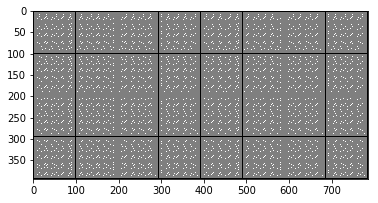

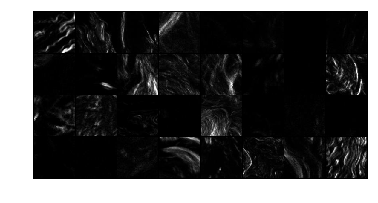

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


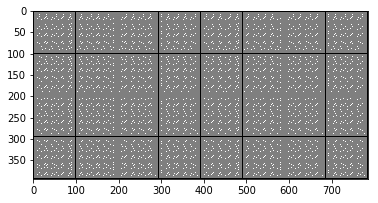

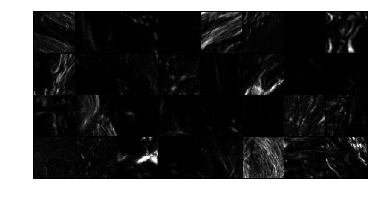

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


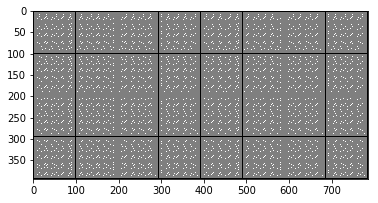

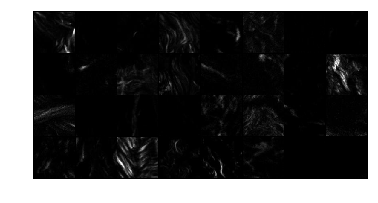

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


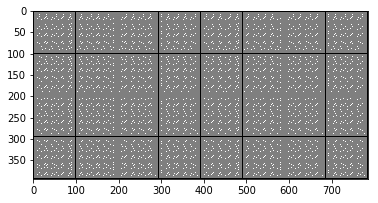

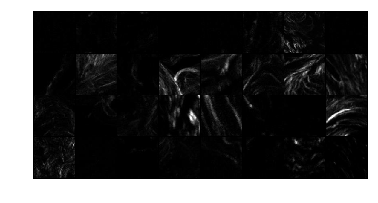

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


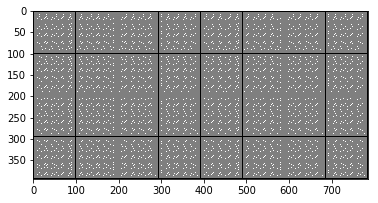

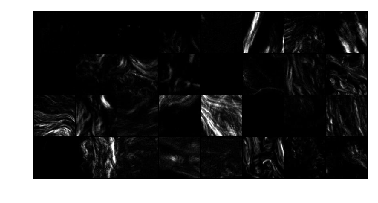

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


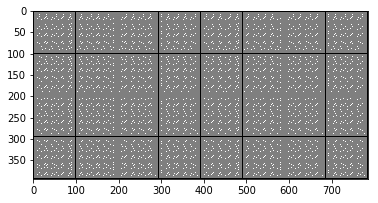

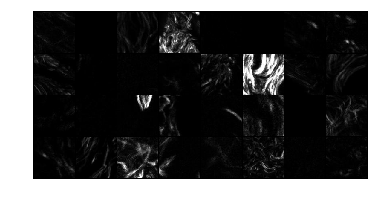

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


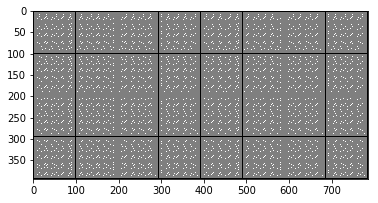

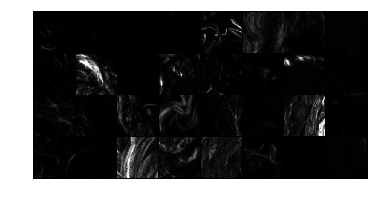

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


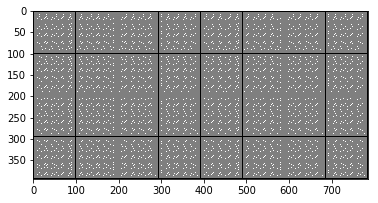

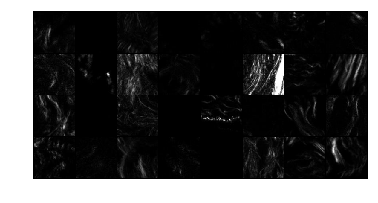

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


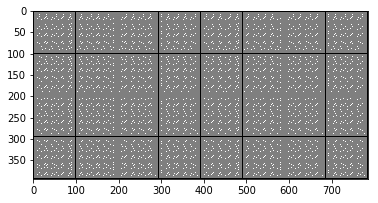

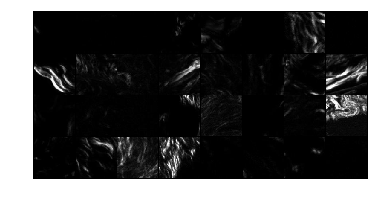

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


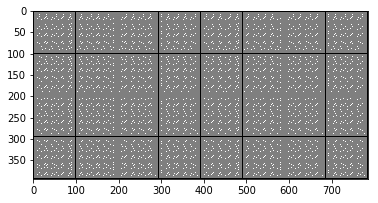

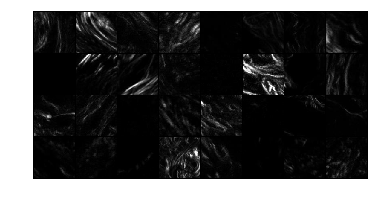

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


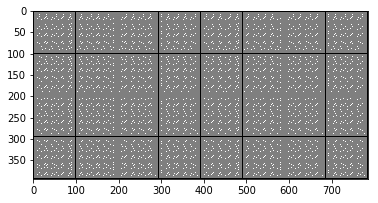

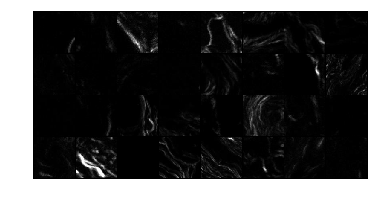

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


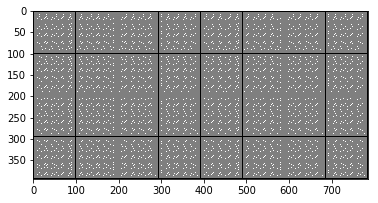

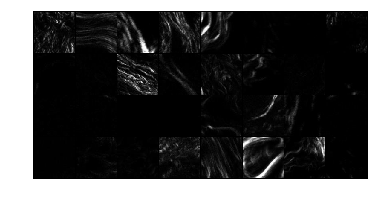

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


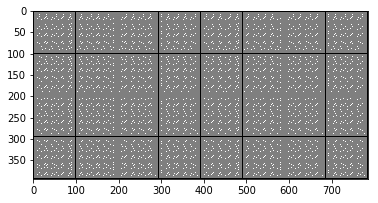

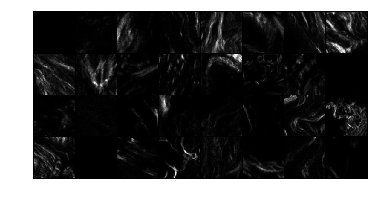

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


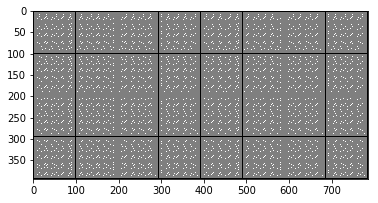

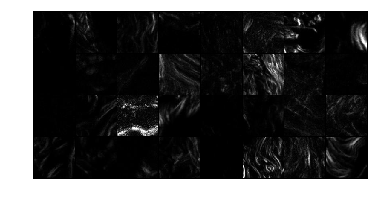

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


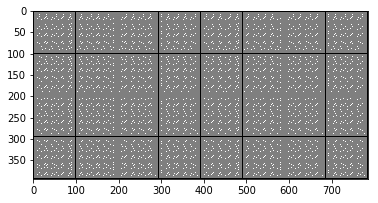

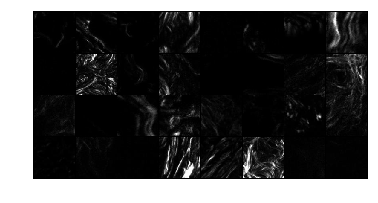

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


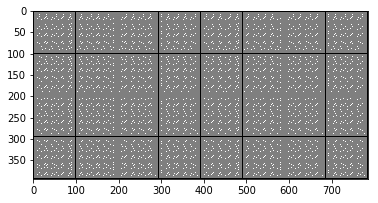

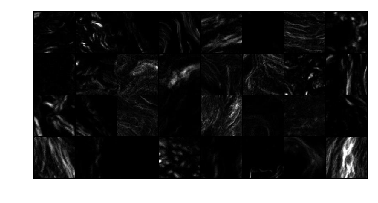

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


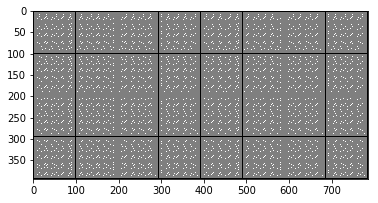

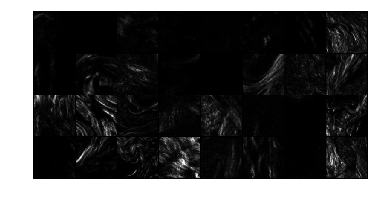

===> Avg. PSNR: 0.0082 dB


In [26]:
test()